In [6]:
import jax.numpy as jnp
# behaves just like numpy!
x = jnp.array([1., 2., 3., 4., 5., 6., 7., 8.])
print(f"{x**2=}")
x = jnp.reshape(x, (8,1))
print(f"{x.T@x=}")
print(f"{x@x.T=}")

x**2=Array([ 1.,  4.,  9., 16., 25., 36., 49., 64.], dtype=float32)
x.T@x=Array([[204.]], dtype=float32)
x@x.T=Array([[ 1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.],
       [ 2.,  4.,  6.,  8., 10., 12., 14., 16.],
       [ 3.,  6.,  9., 12., 15., 18., 21., 24.],
       [ 4.,  8., 12., 16., 20., 24., 28., 32.],
       [ 5., 10., 15., 20., 25., 30., 35., 40.],
       [ 6., 12., 18., 24., 30., 36., 42., 48.],
       [ 7., 14., 21., 28., 35., 42., 49., 56.],
       [ 8., 16., 24., 32., 40., 48., 56., 64.]], dtype=float32)


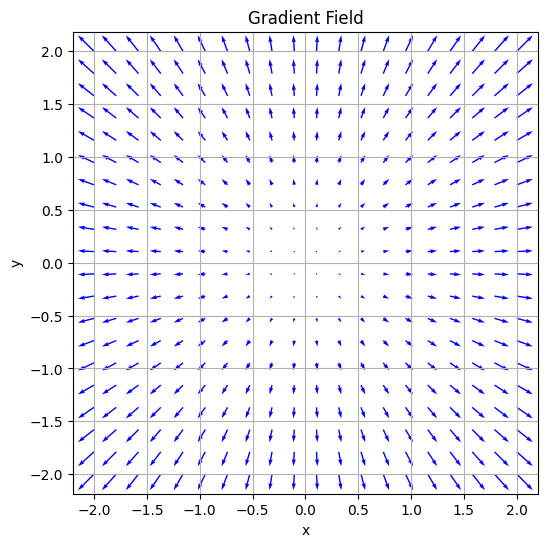

In [18]:
import jax
import matplotlib.pyplot as plt

def f(x): return x[0]**2 + x[1]**2
grad_f = jax.grad(f)

def plot_vector_field(nablaf, xrange=[-2,2], yrange=[-2,2], title="Gradient Field", color='blue'):
    x = jnp.linspace(xrange[0], xrange[1], 20)
    y = jnp.linspace(yrange[0], yrange[1], 20)
    X, Y = jnp.meshgrid(x, y)
    # Evaluate the gradient on the grid
    U = jnp.zeros_like(X)
    V = jnp.zeros_like(Y)

    for i in range(X.shape[0]):
        for j in range(X.shape[1]):
            grad = nablaf(jnp.array([X[i, j], Y[i, j]]))
            U = U.at[i, j].set(grad[0])
            V = V.at[i, j].set(grad[1])
    # Plot the gradient field using quiver
    plt.figure(figsize=(6, 6))
    plt.quiver(X, Y, U, V, color=color)
    plt.title(title)
    plt.xlabel("x")
    plt.ylabel("y")
    plt.axis("equal")
    plt.grid(True)
    plt.show()

plot_vector_field(grad_f)

Now let $f$ depend on a parameter $p$

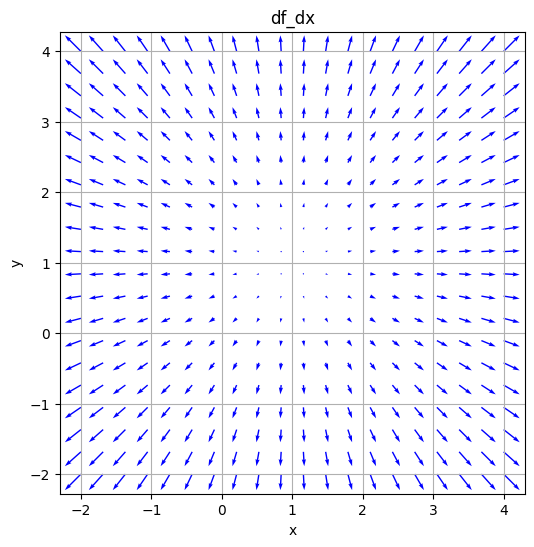

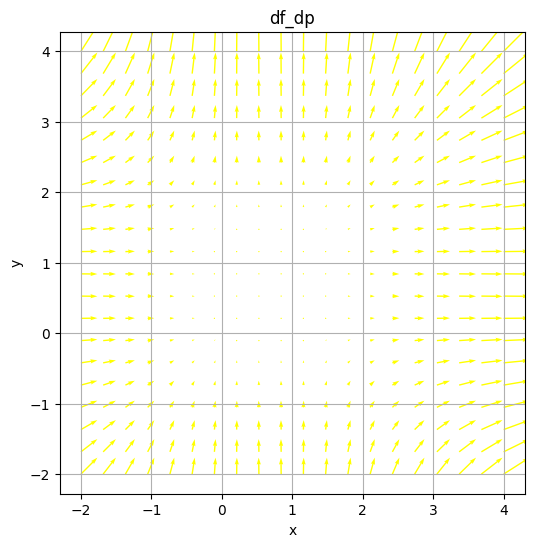

In [20]:
def f(x, p): return p[0]*(x[0]-p[0])**2 + p[1]*(x[1]-p[1])**2

p0 = jnp.array([1,1])
df_dx = jax.grad(lambda x: f(x,p0))
plot_vector_field(df_dx, xrange=[-2,4], yrange=[-2,4], title="df_dx")
x0 = jnp.array([1,1])
df_dp = jax.grad(lambda p: f(x0,p))
plot_vector_field(df_dp, xrange=[-2,4], yrange=[-2,4], title="df_dp", color='yellow')


Now let's make a perceptron

Epoch 0, Loss: 0.0508
Epoch 10, Loss: 0.0502
Epoch 20, Loss: 0.0496
Epoch 30, Loss: 0.0490
Epoch 40, Loss: 0.0485
Epoch 50, Loss: 0.0479
Epoch 60, Loss: 0.0474
Epoch 70, Loss: 0.0469
Epoch 80, Loss: 0.0464
Epoch 90, Loss: 0.0460


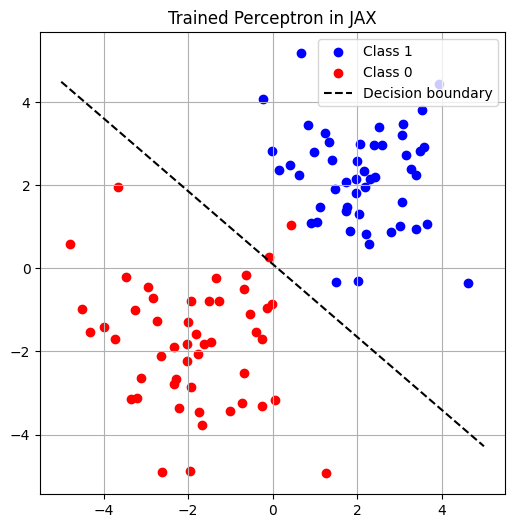

In [28]:
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt

def create_data(svm=False):
    # Generate synthetic data: 2D points
    key = jax.random.PRNGKey(0)
    X_pos = 1.2*jax.random.normal(key, (50, 2)) + jnp.array([2.0, 2.0])
    X_neg = 1.5*jax.random.normal(key, (50, 2)) + jnp.array([-2.0, -2.0])
    X = jnp.concatenate([X_pos, X_neg])
    if svm:
        Y = jnp.concatenate([jnp.ones(50), -jnp.ones(50)])  # SVM uses labels ±1
    else:
        Y = jnp.concatenate([jnp.ones(50), jnp.zeros(50)])
    return key, X, Y, X_pos, X_neg

# Sigmoid activation
def sigmoid(x):
    return 1 / (1 + jnp.exp(-x))

# Perceptron function: y = sigmoid(w · x + b)
def predict(params, x):
    w, b = params
    return sigmoid(jnp.dot(w, x) + b)

# Binary cross-entropy loss
def loss_fn(params, x, y):
    y_pred = predict(params, x)
    return -y * jnp.log(y_pred + 1e-8) - (1 - y) * jnp.log(1 - y_pred + 1e-8)

# Vectorized loss over a batch
@jax.jit
def total_loss(params, X, Y):
    # vectorized version!
    loss_vec = jax.vmap(lambda x, y: loss_fn(params, x, y))
    return jnp.mean(loss_vec(X, Y))

# Gradient descent step
@jax.jit
def update(params, X, Y, lr=0.1):
    grads = jax.grad(total_loss)(params, X, Y)
    return [(w - lr * dw) for w, dw in zip(params, grads)]

# create data
key, X, Y, X_pos, X_neg = create_data()

# Initialize weights and bias
params = [jax.random.normal(key, (2,)), 0.0]

# Training loop
for epoch in range(100):
    params = update(params, X, Y)
    if epoch % 10 == 0:
        l = total_loss(params, X, Y)
        print(f"Epoch {epoch}, Loss: {l:.4f}")

# Plot results
w, b = params
plt.figure(figsize=(6, 6))
plt.scatter(X_pos[:, 0], X_pos[:, 1], color='blue', label='Class 1')
plt.scatter(X_neg[:, 0], X_neg[:, 1], color='red', label='Class 0')

# Decision boundary: w1*x + w2*y + b = 0  => y = -(w1*x + b)/w2
x_line = jnp.linspace(-5, 5, 100)
y_line = -(w[0] * x_line + b) / w[1]
plt.plot(x_line, y_line, 'k--', label='Decision boundary')
plt.legend()
plt.grid(True)
plt.title("Trained Perceptron in JAX")
plt.show()

Same thing with a SVM (well, not really, we use a gradient method...)

Epoch 0, Loss: 0.3814
Epoch 10, Loss: 0.3150
Epoch 20, Loss: 0.2607
Epoch 30, Loss: 0.2161
Epoch 40, Loss: 0.1800
Epoch 50, Loss: 0.1520
Epoch 60, Loss: 0.1303
Epoch 70, Loss: 0.1129
Epoch 80, Loss: 0.0994
Epoch 90, Loss: 0.0881


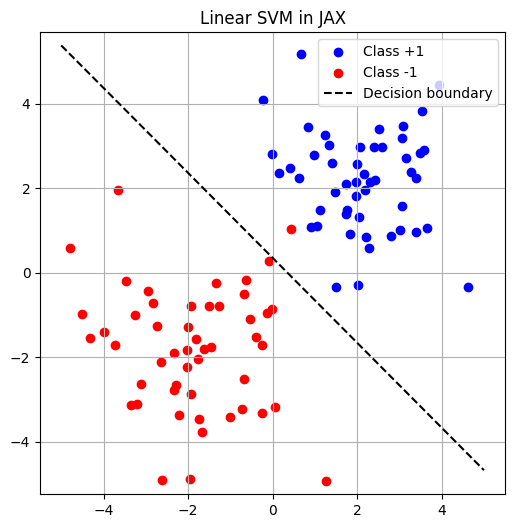

In [30]:
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt

# SVM prediction: w · x + b
def predict(params, x):
    w, b = params
    return jnp.dot(w, x) + b

# Hinge loss for one sample
def hinge_loss(params, x, y):
    return jnp.maximum(0.0, 1.0 - y * predict(params, x))

# Vectorized hinge loss over a batch
@jax.jit
def total_loss(params, X, Y, C=1.0):
    hinge_losses = jax.vmap(hinge_loss, in_axes=(None, 0, 0))(params, X, Y)
    w = params[0]
    return 0.05 * jnp.dot(w, w) + C * jnp.mean(hinge_losses)

# Gradient descent step
@jax.jit
def update(params, X, Y, lr=0.1, C=1.0):
    grads = jax.grad(total_loss)(params, X, Y, C)
    return [(w - lr * dw) for w, dw in zip(params, grads)]

# create data
key, X, Y, X_pos, X_neg = create_data(svm=True)

# Initialize parameters
params = [jax.random.normal(key, (2,)), 0.0]  # (w, b)

# Training loop
for epoch in range(100):
    params = update(params, X, Y, lr=0.1, C=1.0)
    if epoch % 10 == 0:
        l = total_loss(params, X, Y)
        print(f"Epoch {epoch}, Loss: {l:.4f}")

# Plot results
w, b = params
plt.figure(figsize=(6, 6))
plt.scatter(X_pos[:, 0], X_pos[:, 1], color='blue', label='Class +1')
plt.scatter(X_neg[:, 0], X_neg[:, 1], color='red', label='Class -1')

# Decision boundary: w1*x + w2*y + b = 0  => y = -(w1*x + b)/w2
x_line = jnp.linspace(-5, 5, 100)
y_line = -(w[0] * x_line + b) / w[1]
plt.plot(x_line, y_line, 'k--', label='Decision boundary')

plt.legend()
plt.grid(True)
plt.title("Linear SVM in JAX")
plt.axis("equal")
plt.show()